In [1]:
from spine.spine_exam import SpineStudy
from spine.read import read_study
from spine.visualisation.interactive import interactive_visualization, simple_interactive
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import torchvision.transforms.functional as tf
import torch.nn.functional as F
%matplotlib widget

In [2]:
import torch
import torch.nn as nn
from pathlib import Path

import random
import numpy as np
import pandas as pd
import os

import pandas as pd
import torch.utils
import albumentations as A
from torch.utils.data import Dataset, DataLoader
from spine.model.model import RSNASpineLightningModule
from spine.task.dataset import SpinePredictDataset, custom_collate_fn, SpineDataset
from spine.task.tables import read_train_tables


import pytorch_lightning as pl
import os
import math


def _to_path_or_none(path):
    return Path(path) if path is not None else None

dataset_path =  _to_path_or_none(os.environ.get("SPINE_DATASET")) or Path("/home/mkurtys/projects/datasets/spine")
checkpoint = _to_path_or_none(os.environ.get("CHECKPOINT")) or Path("checkpoints/last-v7.ckpt")

# Set random seed
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Read the tables
descriptions = pd.read_csv(dataset_path/"test_series_descriptions.csv")
model = RSNASpineLightningModule.load_from_checkpoint(checkpoint)
model.eval()

descriptions, coordinates, train_melt, train = read_train_tables(dataset_path)

transforms_train = A.Compose([
    A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), p=1.0),
    A.OneOf([
        A.MotionBlur(blur_limit=5),
        A.MedianBlur(blur_limit=5),
        A.GaussianBlur(blur_limit=5),
        A.GaussNoise(var_limit=(5.0, 30.0)),
    ], p=1.0),
])



train_spine_dataset = SpineDataset(dicom_dir=dataset_path/"train_images/",
                                train=train,
                                coordinates=coordinates,
                                descriptions=descriptions,
                                resize=(224,224),
                                transform=None,
                                )

sample = train_spine_dataset[0]
sample = custom_collate_fn([sample])
#sample = {key: value[0] for key, value in sample.items()}
volume = sample["image"]

/home/mkurtys/.pyenv/versions/3.11.1/envs/spine/lib/python3.11/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.17 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
/home/mkurtys/.pyenv/versions/3.11.1/envs/spine/lib/python3.11/site-packages/pydantic/main.py:212: UserWarning: blur_limit and sigma_limit minimum value can not be both equal to 0. blur_limit minimum value changed to 3.
  validated_self = self.__pydantic_validator__.validate_python(data, self_instance=self)


In [3]:
num_point, num_grade = 5*5,3
sample["heatmap"].shape

torch.Size([15, 75, 56, 56])

In [4]:
heatmap = sample["heatmap"]
heatmap = heatmap.permute(1,0, 2, 3)
heatmap = heatmap.reshape(num_point, num_grade, *heatmap.shape[1:])
heatmap.shape

torch.Size([25, 3, 15, 56, 56])

In [5]:
z0 = heatmap.max(dim=0).values
z0 = z0.max(dim=0).values

In [6]:
z=heatmap.max(dim=1).values.argmax(dim=0)


In [7]:
heatmap.reshape(75,-1).max(dim=1)

torch.return_types.max(
values=tensor([1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        1., 0., 0.]),
indices=tensor([23100,     0,     0, 23436,     0,     0, 23828,     0,     0, 24053,
            0,     0, 24335,     0,     0, 32397,     0,     0, 35924,     0,
            0, 36315,     0,     0,     0, 33459,     0, 33741,     0,     0,
        16772,     0,     0, 17052,     0,     0,     0, 14307,     0,     0,
        11507,     0, 11789,     0,     0, 32452,     0,     0, 32844,     0,
            0, 30044,     0,     0,     0, 27244,     0, 30662,     0,     0,
        19964,     0,     0, 20300,     0,     0, 17499,     0,     0, 17836,
            0,     0, 18118,     0,     0]))

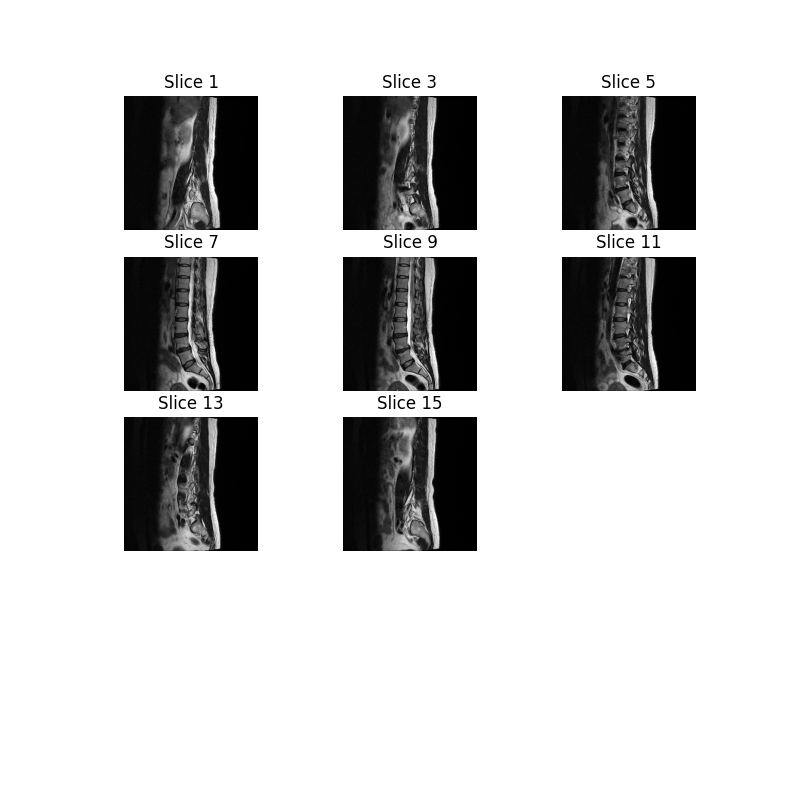

In [8]:
fig = plt.figure(figsize=(8,8))
for i, slice_idx in enumerate(range(0, volume.shape[0], math.ceil(volume.shape[0]/12))):
    ax = fig.add_subplot(4,3,i+1)
    ax.imshow(volume[slice_idx], cmap='gray')
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')

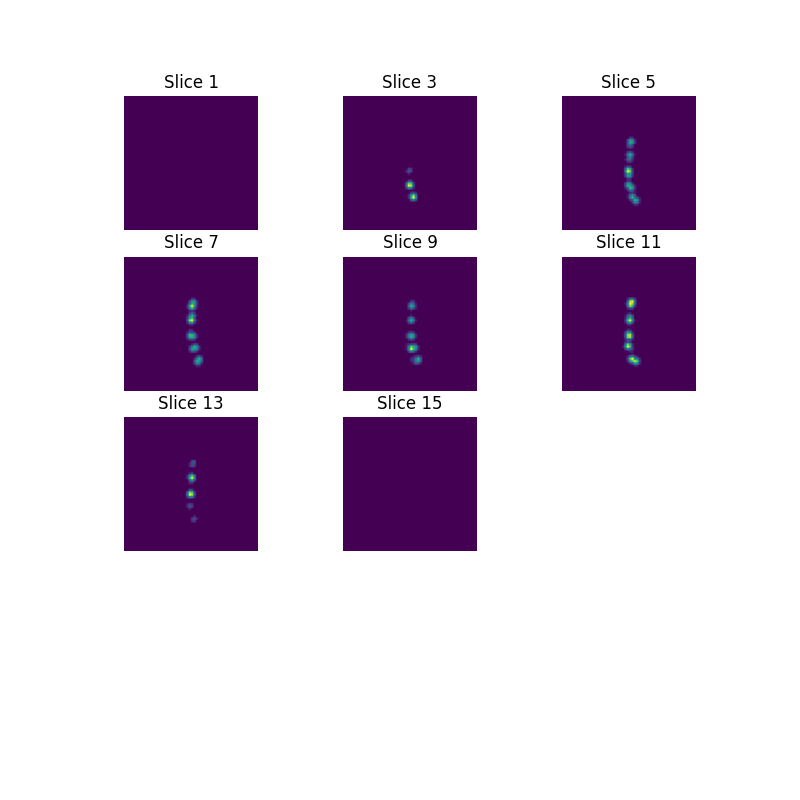

In [9]:
volume=z0
fig = plt.figure(figsize=(8,8))
for i, slice_idx in enumerate(range(0, volume.shape[0], math.ceil(volume.shape[0]/12))):
    ax = fig.add_subplot(4,3,i+1)
    ax.imshow(volume[slice_idx])
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')

In [10]:
data_loader = DataLoader(train_spine_dataset, batch_size=2, shuffle=False, collate_fn=custom_collate_fn)

In [11]:
b = next(iter(data_loader))

In [12]:
for key, value in b.items():
    print(key, value.shape)

study_id torch.Size([2])
D torch.Size([2])
image torch.Size([32, 224, 224])
coords torch.Size([2, 25, 3])
coords_mask torch.Size([2, 25])
grade torch.Size([2, 25])
heatmap torch.Size([32, 75, 56, 56])


In [13]:
o = model({k:v.to(model.device) for k,v in b.items()})
o["heatmap"][0].shape

pos_loss -39.20205307006836 neg_loss -0.2825755774974823 num_pos 25.0 num_neg 3527975
pos_loss -76.47529602050781 neg_loss -0.140968456864357 num_pos 25.0 num_neg 3998375


torch.Size([25, 3, 15, 56, 56])

In [14]:
volume = b["image"][:b["D"][0], ...]
volume.shape

torch.Size([15, 224, 224])

In [15]:
level_color = [
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1],
    [1, 1, 0],
    [0, 1, 1],
]

In [16]:
o["heatmap"][0].flatten(end_dim=1).detach().shape

torch.Size([75, 15, 56, 56])

In [17]:
b["heatmap"][:b["D"][0], ...].detach().shape

torch.Size([15, 75, 56, 56])

In [18]:
transforms_train(image=b["image"][:b["D"][0], ...].detach().cpu().numpy())

{'image': array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        ...,
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 

In [19]:
#volume=o["heatmap"][0].max(dim=1).values.max(dim=0).values.detach().cpu().numpy()
hmap=o["heatmap"][0].flatten(end_dim=1).detach()
#hmap=b["heatmap"][:b["D"][0], ...].detach().permute(1,0,2,3)
volume = b["image"][:b["D"][0], ...].detach()
# (5,3) -> (5,5,3,3)
color_t = torch.tensor(level_color, device=hmap.device, dtype=torch.float32).repeat(5, 3)
print("hmap shape", hmap.shape)
print("MAX", torch.amax(hmap, dim=(1, 2,3)).reshape(25,3))
print("SUM", torch.sum(hmap, dim=(1, 2,3)).reshape(25,3))

h = F.interpolate(hmap.unsqueeze(0), scale_factor=(1,4,4), mode='nearest').squeeze(0)
print(" color ", color_t.shape)
print(h.shape)
print(h[0].amax(dim=(1,2)))

hmap shape torch.Size([75, 15, 56, 56])
MAX tensor([[3.8066e-01, 2.9154e-04, 7.9192e-07],
        [6.8842e-01, 1.8412e-04, 6.4552e-06],
        [8.4477e-01, 1.2784e-03, 1.4080e-06],
        [6.2681e-01, 4.2637e-03, 6.6792e-04],
        [3.0496e-01, 8.3890e-04, 5.9881e-06],
        [6.1079e-01, 3.7080e-05, 2.5054e-08],
        [2.3735e-01, 6.1452e-04, 6.3793e-07],
        [4.8266e-01, 2.6121e-03, 1.8634e-04],
        [3.2470e-01, 9.2719e-02, 9.0224e-03],
        [5.0639e-01, 7.4850e-03, 5.2590e-05],
        [3.7792e-01, 5.6044e-05, 3.5073e-07],
        [4.9891e-01, 2.4348e-03, 3.5802e-06],
        [4.0748e-01, 1.2382e-02, 2.1328e-05],
        [2.5214e-01, 4.3712e-02, 3.7443e-04],
        [2.3009e-01, 4.1125e-02, 2.1029e-04],
        [4.4097e-01, 6.0952e-04, 2.0851e-05],
        [3.1078e-01, 2.1825e-03, 1.4936e-05],
        [2.3101e-01, 4.9763e-03, 2.2814e-04],
        [7.8671e-02, 1.4890e-01, 1.5306e-01],
        [4.4533e-01, 4.6299e-03, 1.1404e-04],
        [2.8908e-01, 1.0521e-04, 5.6

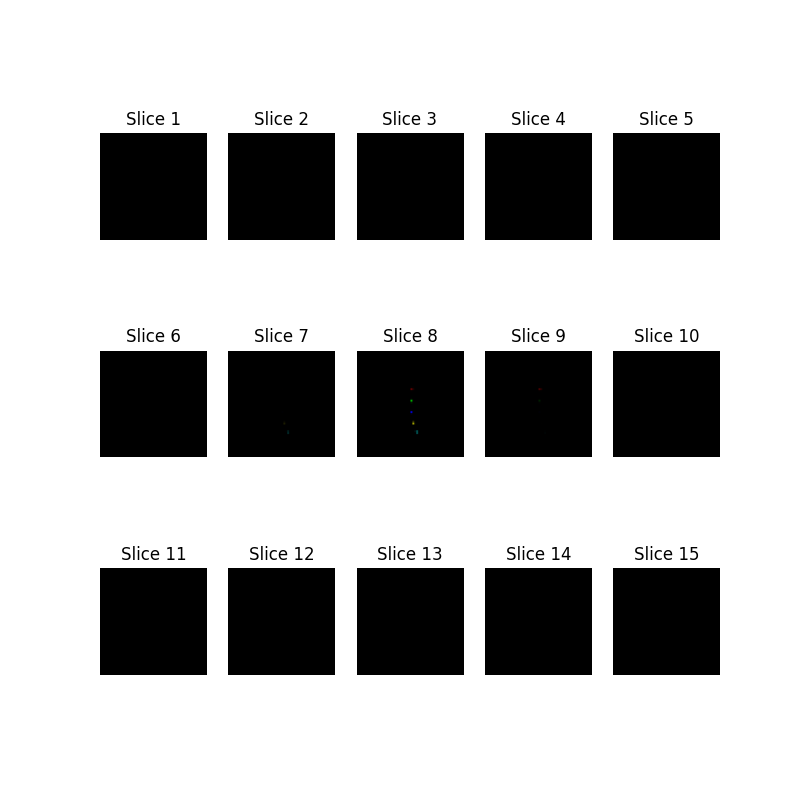

In [20]:

n_slices = 15
fig, axs = plt.subplots(3,5, figsize=(8,8))
stride = math.ceil(volume.shape[0]/n_slices)
for i, slice_idx in enumerate(range(0, volume.shape[0], stride)):
    ax = axs.flatten()[i]
    low = slice_idx
    high = min(volume.shape[0], slice_idx+stride)
    thick_slice = volume[low:high].mean(0)
    # print("slice max", thick_slice.max())
    hmap_slice = h[:, low:high, ...].max(1).values

    hmap_slice = hmap_slice.unsqueeze(1).expand(hmap_slice.shape[0], 3, *hmap_slice.shape[1:])*color_t.reshape(75,3,1,1)
    # print(hmap_slice.shape)
    hmap_rgb = hmap_slice[:15, ...].sum(0).permute(1,2,0)
    # print("hmap max", hmap_rgb.max())
    # ax.imshow(torch.stack([thick_slice]*3).permute(1,2,0).cpu() + hmap_rgb.cpu())
    ax.imshow(hmap_rgb.cpu())
    ax.set_title(f'Slice {slice_idx+1}')
    ax.axis('off')

In [23]:
B=10
torch.tensor([[0,0,1]*25]*B).reshape(B, 25, 3).shape

torch.Size([10, 25, 3])

In [24]:
hmap.shape

torch.Size([75, 15, 56, 56])

In [36]:
m, i=hmap.flatten(1).max(1)
torch.unravel_index(i, (56, 56))

(tensor([20, 20, 20, 26, 26, 26, 32, 32, 32, 38, 38, 38, 43, 42, 43, 18, 18, 37,
         25, 24, 24, 31, 31, 37, 37, 37, 37, 42, 42, 42, 19, 19, 19, 25, 25, 25,
         31, 31, 31, 36, 36, 37, 42, 42, 42, 20, 20, 21, 26, 27, 27, 33, 33, 38,
         38, 38, 38, 43, 43, 43, 20, 21, 21, 26, 26, 27, 32, 32, 33, 38, 38, 38,
         43, 43, 43], device='cuda:0'),
 tensor([28, 28, 31, 28, 28, 28, 28, 28, 28, 29, 29, 29, 31, 31, 31, 28, 28, 28,
         28, 28, 28, 27, 27, 28, 27, 27, 28, 28, 28, 28, 28, 28, 29, 27, 27, 27,
         27, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 28, 28, 27, 27, 28, 27, 29,
         28, 28, 28, 30, 30, 30, 28, 28, 28, 28, 27, 27, 27, 27, 27, 28, 28, 28,
         30, 30, 30], device='cuda:0'))

In [39]:
torch.arange(500).reshape(5,10,10)[..., [1,2], [1,2]]

tensor([[ 11,  22],
        [111, 122],
        [211, 222],
        [311, 322],
        [411, 422]])

In [40]:
torch.arange(12).reshape(3,4).max(dim=1).values

tensor([ 3,  7, 11])